Working directory: C:\Python

📊 Test Metrics:
   Accuracy  Precision    Recall        F1
0  0.733854   0.499174  0.807487  0.616956

📄 Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.71      0.80      1035
         Yes       0.50      0.81      0.62       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409


🔢 Confusion Matrix:
[[732 303]
 [ 72 302]]


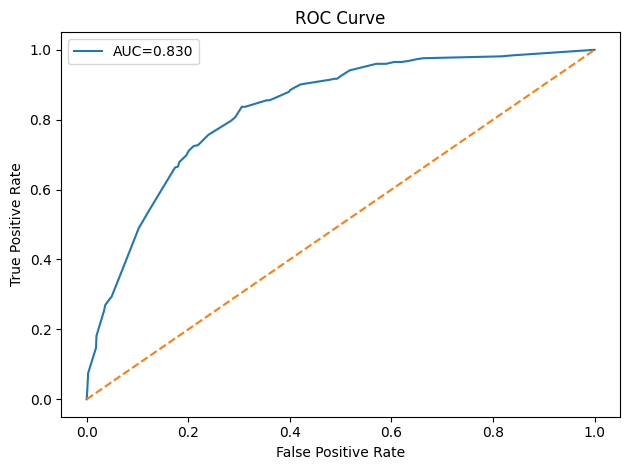


🏆 Top Feature Importances:
                        feature  importance
8       Contract_Month-to-month    0.521787
1                MonthlyCharges    0.139709
0                        tenure    0.130836
6   InternetService_Fiber optic    0.097464
2                  TotalCharges    0.056803
9             Contract_One year    0.027122
7            InternetService_No    0.012769
10            Contract_Two year    0.005050
3                 gender_Female    0.004230
4                   gender_Male    0.004229
5           InternetService_DSL    0.000000


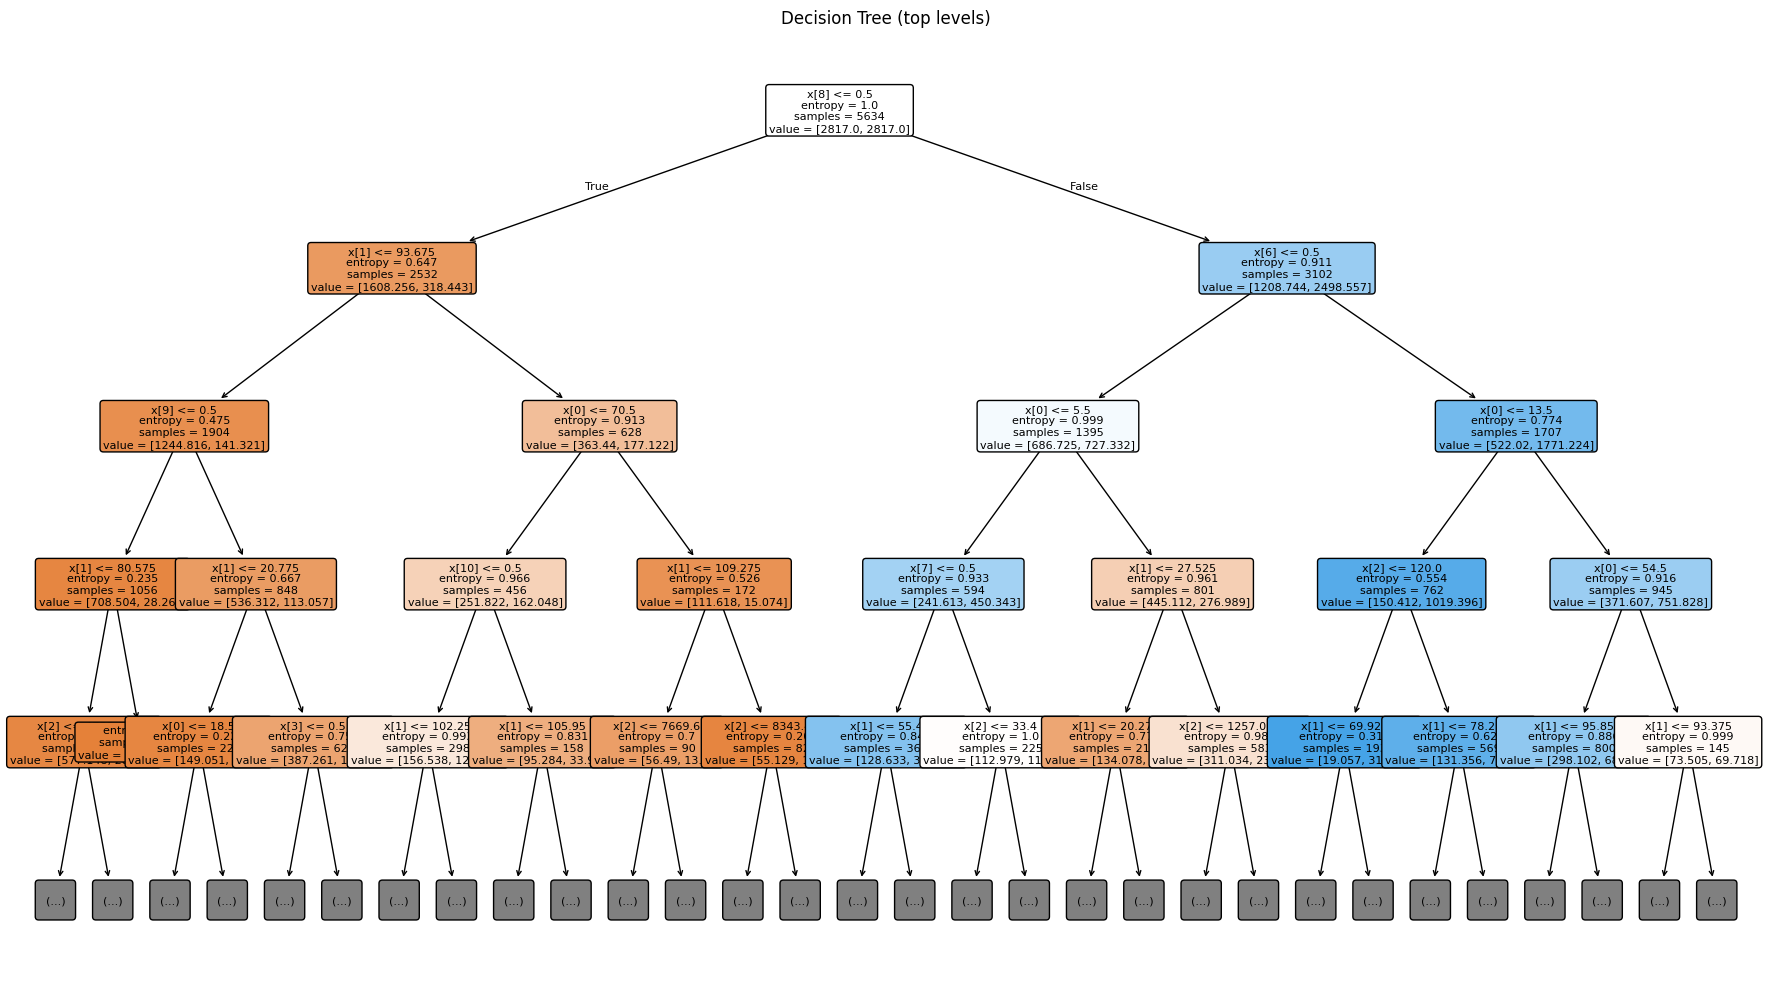

{'best_params': {'model__criterion': 'entropy',
  'model__max_depth': 6,
  'model__min_samples_leaf': 20},
 'metrics_csv': 'churn_outputs_fast\\test_metrics.csv',
 'confusion_matrix_csv': 'churn_outputs_fast\\confusion_matrix.csv',
 'feature_importances_csv': 'churn_outputs_fast\\feature_importances.csv',
 'scored_holdout_csv': 'churn_outputs_fast\\scored_holdout.csv'}

In [15]:
# ===============================
# Customer Churn Prediction (Decision Tree, Fast Version)
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_auc_score,
    roc_curve, confusion_matrix
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
import os

print("Working directory:", os.getcwd())

# ---------- Load ----------
path = "Telco-Customer-Churn.csv"  # <-- keep your CSV here
df = pd.read_csv(path)

# Clean + encode
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", np.nan), errors="coerce")
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype("Int64")
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "Churn"]
categorical_cols = [c for c in df.columns if c not in numeric_cols + ["Churn"]]

X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing
numeric_transformer = SimpleImputer(strategy="median")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    [("num", numeric_transformer, numeric_cols),
     ("cat", categorical_transformer, categorical_cols)]
)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")

param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__max_depth": [4, 6, 8, None],
    "model__min_samples_leaf": [1, 10, 20]
}
pipe = Pipeline([("preprocess", preprocess), ("model", dt)])

grid = GridSearchCV(pipe, param_grid=param_grid, scoring="f1", cv=3, n_jobs=1, verbose=0)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1": f1_score(y_test, y_pred, zero_division=0)
}
print("\n📊 Test Metrics:")
print(pd.DataFrame([metrics]))

# Classification report (inline, not TXT)
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No", "Yes"], zero_division=0))

# Confusion matrix (inline + save CSV)
cm = confusion_matrix(y_test, y_pred)
print("\n🔢 Confusion Matrix:")
print(cm)

# Save outputs (only CSV files)
eda_dir = "churn_outputs_fast"
os.makedirs(eda_dir, exist_ok=True)
pd.DataFrame([metrics]).to_csv(os.path.join(eda_dir, "test_metrics.csv"), index=False)
np.savetxt(os.path.join(eda_dir, "confusion_matrix.csv"), cm, delimiter=",", fmt="%d")

# ROC Curve - show inline only
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importances
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
ohe_features = list(ohe.get_feature_names_out(categorical_cols))
feature_names = numeric_cols + ohe_features
importances = best_model.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
fi.to_csv(os.path.join(eda_dir, "feature_importances.csv"), index=False)

print("\n🏆 Top Feature Importances:")
print(fi.head(20))

# Decision Tree - inline visualization
plt.figure(figsize=(18, 10))
plot_tree(best_model.named_steps["model"], max_depth=4, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree (top levels)")
plt.tight_layout()
plt.show()

# Save scored holdout
preds = pd.DataFrame({"predicted_churn": y_pred, "proba_churn": y_prob}, index=X_test.index)
scored = pd.concat([df.loc[X_test.index].reset_index(drop=True), preds.reset_index(drop=True)], axis=1)
scored_path = os.path.join(eda_dir, "scored_holdout.csv")
scored.to_csv(scored_path, index=False)

{
    "best_params": grid.best_params_,
    "metrics_csv": os.path.join(eda_dir, "test_metrics.csv"),
    "confusion_matrix_csv": os.path.join(eda_dir, "confusion_matrix.csv"),
    "feature_importances_csv": os.path.join(eda_dir, "feature_importances.csv"),
    "scored_holdout_csv": scored_path
}
